In [3]:
options(warn=-1)

library('igraph')
library('Matrix')
library('pracma')

create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

random_walk = function (g, num_steps, start_node, tele_prob = 0, transition_matrix = NULL, PageRank=NULL){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    vert = seq_len(0)
    v = start_node
    vert = c(vert, v)
    for(i in 1:num_steps){
#       fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        jump = sample(c(0, 1), 1, prob = c(1 - tele_prob, tele_prob))
        PMF = PageRank
        if (jump == 0) {
            PMF = transition_matrix[v, ]
        }
        v = sample(1:vcount(g), 1, prob = PMF) 
        vert = c(vert, v)
    }
    
    return(vert)
}

freq = function (vertex_sequence, num_vertex, num_steps) {
    name = names(table(vertex_sequence))
    count = as.numeric(table(vertex_sequence))
    result = seq_len(0)
    for (i in 1:num_vertex){
        if(i %in% name){
            result = c(result, count[i]/(num_steps + 1))
        }
        else
            result = c(result, 0)
    }
    result[is.na(result)] = 0
    return(result)
}

In [5]:
random_network = barabasi.game(1000, m = 4, directed = TRUE)
set.seed(1)
start_node = sample(1:vcount(random_network), 1)
vertex_sequence = random_walk(random_network, 1000, start_node, tele_prob=0.15)
PageRank = freq(vertex_sequence, 1000, 1000)

### (a)

In [9]:
vertex_sequence_a = random_walk(random_network, 1000, start_node, tele_prob=0.15, PageRank=PageRank)
vertex_sequence_a

When using teleportation based on PageRank, random jump will favor nodes with high PageRank values. Different from the result in 3b, which uses random jump with uniform distribution over all pages, the result in this problem is more likely to land onto vertices with high page rank values, like the first few nodes.The distribution becomes more concentrated in this case due to the random jump probability being affected by initial PageRank obtained from 3b

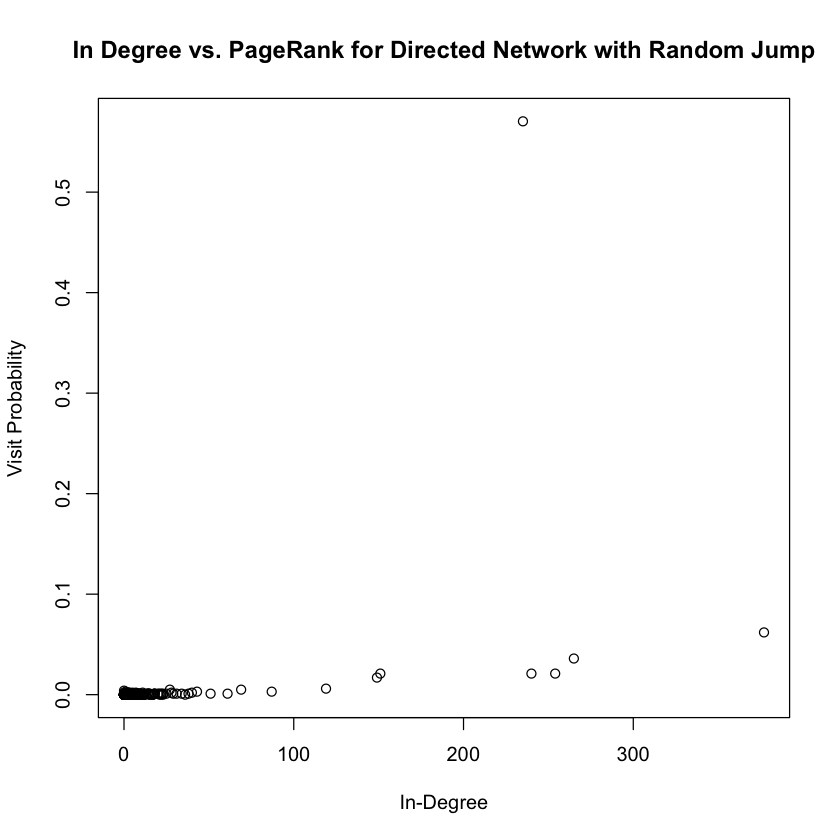

In [19]:
network_in_degree = degree(random_network, mode = "in")
in_relationship = cor(network_in_degree, PageRank)
plot_data = rbind(network_in_degree, PageRank)
plot_data = plot_data[,order(plot_data[1,])]  #order by degree
plot(plot_data[1,], plot_data[2,], xlab = "In-Degree", ylab = "Visit Probability", main = "In Degree vs. PageRank for Directed Network with Random Jump")

Correlation between in-degree and PageRank 0.3630926 


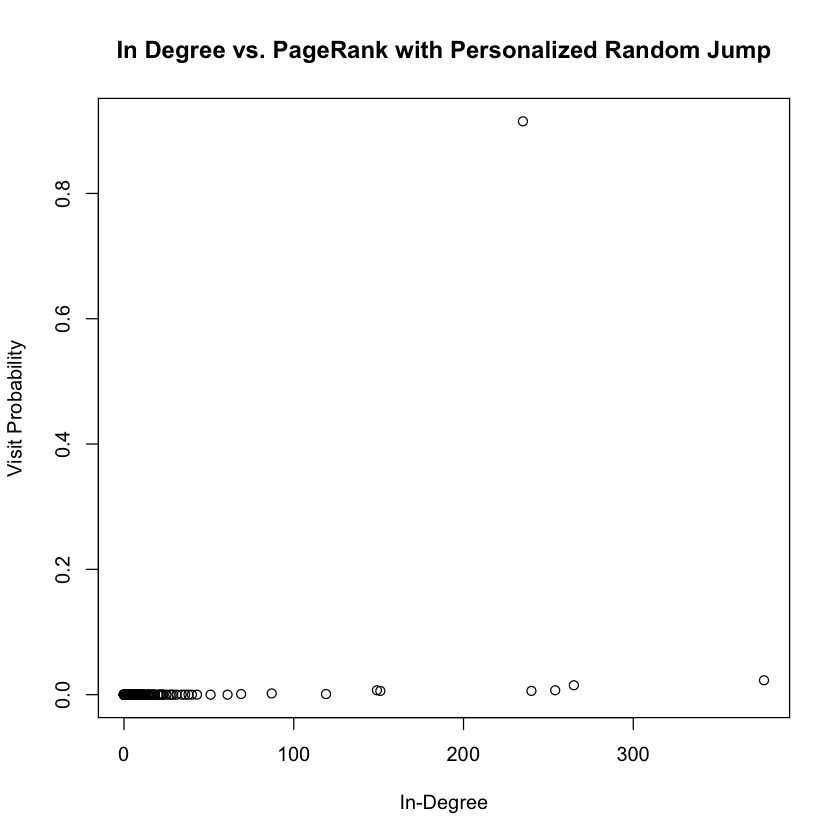

In [23]:
pg_1 = freq(vertex_sequence_a, 1000, 1000)
network_in_degree = degree(random_network, mode = "in")
plot_data = rbind(network_in_degree, pg_1)
plot_data = plot_data[,order(plot_data[1,])]  #order by degree
plot(plot_data[1,], plot_data[2,], xlab = "In-Degree", ylab = "Visit Probability", main = "In Degree vs. PageRank with Personalized Random Jump")
in_relationship = cor(network_in_degree, pg_1)
cat("Correlation between in-degree and PageRank", in_relationship, "\n")

In [38]:
PageRank = integer(1000)
PageRank[10] = 0.5
PageRank[11] = 0.5
start_node = sample(1:vcount(random_network), 1)
vertex_sequence = random_walk(random_network, 1000, start_node, tele_prob=0.15, PageRank=PageRank)
PageRank = freq(vertex_sequence, 1000, 1000)

### (b)
After setting the favorite page to two medians, the PageRank of these two pages greatly increased. Other pages PageRank decreased significantly due to the biased random jump probability.

### (c)

Let's consider the normal PageRank equation,

 Pr(A) = $\frac{(1 - d)}{N} + d\sum_{T_in} \frac{Pr(T_in)}{C(T_in)}$

, where  Pr(A) is the PageRank of page  A, d is the damping factor, $N$ is the total number of pages or nodes, $T_in$ is the set of nodes which has an edge directed to $A, C(T_in)$ is the number of edges of$ T_in$.

To take into account the effect of user's self-reinforcement, we can change the teleportation probability from  $\frac{1}{N} $to a number which reflects users' interest or trust on site  A .